# Computational Methods in Simulation (CMIS) Week 7
This notebook is intended to help students make their hand-in in the last two weeks of CMIS.

Hand-ins must be submitted as a maximum 10 page pdf file in Absalon and must be made using the ACM TOG overleaf latex template

https://www.overleaf.com/latex/templates/association-for-computing-machinery-acm-large-2-column-format-template/qwcgpbmkkvpq

Notebooks must be uploaded as well so teachers have code solutions accessible if needed.

This week is based on Slides 21 - follow the detailed instructions in order to build your own simulator:

* Hints: You might want to re-visit your FEM and FVM code pieces and reuse subparts of them for this larger project. The meshing week might prove useful for creating your own test cases to play with.

* Derive theory of how to create your own FVM simulator for simulating dynamic hyperelastic materials using a Saint-Vernant-Kirchoff model and a semi-implicit time-stepping scheme.
* Design experiments for verification and validation of your own simulator
* Present results of your experiments and discuss your findings
* If time is available try and extend the simulator to use adaptive or higher order time-stepping
* If time is available try and extend the simulator to use other types of material models
* If time is available try and extend the simulator to have dynamic boundary conditions to model "contact" when objects move around.

## Important Remark

* Do not be too agressive in terms of too large time-step size, too stiff materials and too large gravity. The semi-explicit nature of this overall method is quite sensitive, so use soft materials, almost no gravity and very small time-steps is recommended for prototyping and initial implementation. Once, it has been verified that code works, one can crank up values as close to reality as possible.

## Detailed Expected Learning Objectives in The Hand-in of this Week

* Combine and show all skills learned through out the course.
* Design interesting and relevant experiments for verification and validation.
* Successfully create and discuss experimental results.
* Demonstrate ability to scientific discuss and reflect on the simulator.

In [1]:
%matplotlib widget

In [2]:
import igl
import meshplot as mp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Handling Mesh Geometry Information
In this week we may be able to resue material from previous weeks. In particular the beam mesh genreation function will be useful to us.

However, we make one important slight change to this mesh generation function to avoid ear-triangles when we ask it to generate an even number of horitonal and vertical nodes.

Ear triangles form a degenerate control volume and we do not like them for this reason. The most easy fix is to make sure we never generate ear-triangle in the first place.

In [3]:
def vec2(x,y):
    return np.array([x, y],dtype=np.float64)


def hat(p):
    return vec2(-p[1], p[0])


def compute_triangle_areas(V,T):
    E = len(T) # Total number of triangles in the mesh
    A = np.zeros((E,),dtype=np.float64)
    for e in range(E):
        # Get triangle indices
        i = T[e,0]
        j = T[e,1]
        k = T[e,2]
        # Get triangle coordinates
        xi = V[i,0]
        xj = V[j,0]
        xk = V[k,0]
        yi = V[i,1]
        yj = V[j,1]
        yk = V[k,1]    
        
        dx1 = xk - xj
        dy1 = yk - yj
        dx2 = xi - xj
        dy2 = yi - yj

        A[e] =  (dx1*dy2 - dx2*dy1 ) / 2.0
    return A


def make_beam_mesh(width, height, shape):
    x0 = -width/2.0
    y0 = -height/2.0
    I  = shape[0]
    J  = shape[1]
    dx = width/float(I)
    dy = height/float(J)
    V = np.zeros(((I+1)*(J+1),2),dtype=np.float64)
    for j in range(J+1):
        for i in range(I+1):
            k = i + j*(I+1)
            V[k,0] = x0 + i*dx
            V[k,1] = y0 + j*dy
    T = np.zeros((2*I*J,3),dtype=np.int32)
    for j in range(J):
        for i in range(I):
            k00 = (i  ) + (j  )*(I+1)
            k01 = (i+1) + (j  )*(I+1)
            k10 = (i  ) + (j+1)*(I+1)
            k11 = (i+1) + (j+1)*(I+1)
            e = 2*(i + j*I)
            if (i+j+1)%2:
                T[e,  :] = (k00,k01,k11)
                T[e+1,:] = (k00,k11,k10)
            else:
                T[e,  :] = (k10,k00,k01)
                T[e+1,:] = (k10,k01,k11)                    
    return V, T

Later we will need to build a data structure for our control volumes. To create the control volumes we need to be able to query the mesh about connectivity information and geometric information as well. That is things like all triangles that share the same vertex or the outward unit normals of a triangle and so on.

To make this easy we provide a MeshInfo class that encapsulates simple libigl functionality into a more human readiable interface.

It is a great help to know how to "jump" around neighbors in a mesh data structure. We encourage therefore that students spend a bit of time getting into how this works so they can extend and customize their data structures as they need to with little effort.

In [4]:
class MeshInfo:
    
    def __init__(self, V, T):        
        self.A = compute_triangle_areas(V,T)
        if np.any(np.where(self.A<=0)):
            raise ValueError('Triangle with negative orientation exist.')
        bc = igl.barycenter(V,T)
        E = igl.edges(T)
        TT, _ = igl.triangle_triangle_adjacency(T)
        VT, NI = igl.vertex_triangle_adjacency(T, len(V))
        VV = igl.adjacency_list(T)
        self.V = V    # Vertices
        self.T = T    # Triangles
        self.E = E    # Edges
        self.TT = TT  # Triangle neighbors of triangles
        self.VT = VT  # Triangle neighbors of vertices
        self.NI = NI  # Vertex neighbor indices used to extract triangle neighbors of vertices
        self.VV = VV  # Vertex neighbors of vertices
        self.bc = bc  # Barycenters of triangles        
        mask = np.zeros(len(V),dtype=np.int)
        mask[igl.boundary_loop(T)] = 1
        self.boundary_vertex = mask # Boundary mask of vertices, if 1 then a vertex is boundary otherwise it is interior.
        
    def get_triangles_of_vertex(self, i):
        start = self.NI[i]
        end = self.NI[i+1]
        return self.VT[ start:end]

    def get_triangles_of_triangle(self, t):
        return self.TT[t]
    
    def get_triangle_center(self,t):
        return self.bc[t]
    
    def get_vertices_of_vertex(self, i):
        return self.VV[i]
    
    def get_triangle_area(self,t):
        return self.A[t]
    
    def get_edge_vector_of_triangle(self, t, e):
        i = self.T[t,e]
        j = self.T[t,(e+1)%3]
        vi = self.V[i,:].flatten()
        vj = self.V[j,:].flatten()
        u = (vj-vi).flatten()
        return u, (vi+vj)/2

    def get_outward_normal_of_triangle(self, t, e):
        u, m = self.get_edge_vector_of_triangle(t,e)
        n = -hat(u)/np.linalg.norm(u)
        return n, m
    
    def get_triangle_triangle_segment(self, t, e):
        n = self.TT[t,e]
        if n>0:
            ct = self.bc[t].flatten()
            cn = self.bc[n].flatten()
            return cn-ct, (cn+ct)/2
        return None, None    

    def get_opposing_triangle(self, t, v):
        e = (v+1)%3
        return self.TT[t,e]
    
    def is_boundary_vertex(self,v):
        if self.boundary_vertex[v]==1:
            return True
        return False

We will now run a simplel test example of the mesh generation and mesh info data structure to verify that things are working as expected. 

In particular we want to make sure we have no ears in the mesh, and all neighborhood information are in order too.

c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


vertex  0  has triangle neighbors  [0 1]
vertex  1  has triangle neighbors  [0 2]
vertex  2  has triangle neighbors  [2 3]
vertex  3  has triangle neighbors  [1 4]
vertex  4  has triangle neighbors  [0 1 2 3 4 5 6 7]
vertex  5  has triangle neighbors  [3 6]
vertex  6  has triangle neighbors  [4 5]
vertex  7  has triangle neighbors  [5 7]
vertex  8  has triangle neighbors  [6 7]
Triangle  0  has triangle neighbors  [-1  2  1]
Triangle  1  has triangle neighbors  [ 0  4 -1]
Triangle  2  has triangle neighbors  [ 0 -1  3]
Triangle  3  has triangle neighbors  [ 2 -1  6]
Triangle  4  has triangle neighbors  [-1  1  5]
Triangle  5  has triangle neighbors  [ 4  7 -1]
Triangle  6  has triangle neighbors  [ 3 -1  7]
Triangle  7  has triangle neighbors  [ 6 -1  5]
vertex  0  has vertex neighbors  [1, 3, 4]
vertex  1  has vertex neighbors  [0, 2, 4]
vertex  2  has vertex neighbors  [1, 4, 5]
vertex  3  has vertex neighbors  [0, 4, 6]
vertex  4  has vertex neighbors  [0, 1, 2, 3, 5, 6, 7, 8]
verte

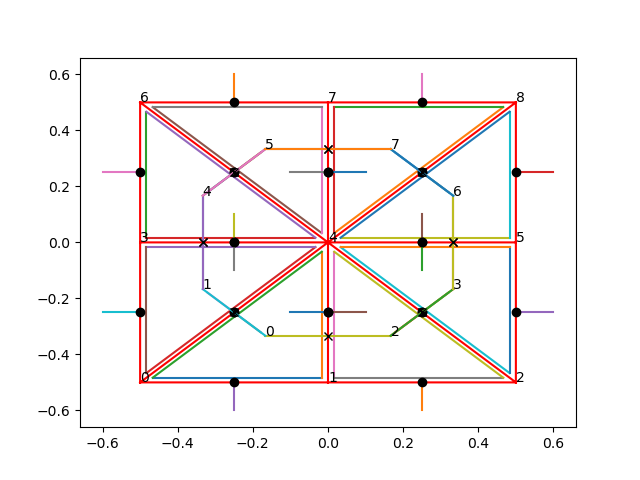

In [5]:
V, T = make_beam_mesh(1.0,1.0,(2,2))

info = MeshInfo(V,T)

fig = plt.figure()
plt.triplot(info.V[:,0],info.V[:,1],info.T,color='r')
for v in range(len(V)):
    print('vertex ',v , ' has triangle neighbors ',info.get_triangles_of_vertex(v))
    plt.text(info.V[v,0],info.V[v,1], str(v))
for t in range(len(T)):
    print('Triangle ',t , ' has triangle neighbors ',info.get_triangles_of_triangle(t))
    c = info.get_triangle_center(t)
    plt.text(c[0],c[1], str(t))
for v in range(len(V)):
    print('vertex ',v , ' has vertex neighbors ',info.get_vertices_of_vertex(v))
for t in range(len(T)):
    c = info.get_triangle_center(t)
    for e in range(3):
        u, m = info.get_edge_vector_of_triangle(t,e)
        v = m - 0.5*u
        w = m + 0.5*u
        m = (m-c)*0.9 + c
        v = (v-c)*0.9 + c
        w = (w-c)*0.9 + c
        plt.plot([v[0], w[0]], [v[1], w[1]] )
for t in range(len(T)):
    for e in range(3):
        n, m = info.get_outward_normal_of_triangle(t,e)
        plt.plot([m[0], 0.1*n[0]+m[0]], [m[1], 0.1*n[1]+m[1]] )
        plt.plot(m[0], m[1],'ko')
for t in range(len(T)):
    for e in range(3):
        u, m = info.get_triangle_triangle_segment(t,e)
        if not u is None: 
            v = m - 0.5*u
            w = m + 0.5*u
            plt.plot([v[0], w[0]], [v[1], w[1]] )
            plt.plot(m[0], m[1],'kx')
plt.show()    

# Creating Vertex-centered Control Volumes
We may now use the mesh information functionality to quickly generate a simple control volume data structure.

We will take a rather brute-force approach and simply create a chunk of vertex-related information that is very specific to the simulation method we will immplement here.

We will exploit one very smart trick here which is to make a cyclic permulation a local copy of neighboring triangles such that the first index of each triangle is the vertex that they all have in common.

This is cleaver later on at run-time as we have explicit knowledge of where the two other vertices of each triangle is located in the vertex neighborhood. Further, it enable us to deduce a CCW order of triangles around a vertex. Although in this example we have little use of this knowledge.

In [6]:
def get_cyclic_permuation(v, triangle):
    i = triangle[0]
    j = triangle[1]
    k = triangle[2]
    if i==v:
        return [i, j, k]
    if j==v:
        return [j, k, i]
    if k==v:
        return [k, i, j]
    return [-1, -1, -1]


def get_ccw_triangle_order(v, T):
    for t in range(len(T)):
        T[t,:] = get_cyclic_permuation(v, T[t,:])    
    if len(T) == 1:
        ccw_order = np.array([0], dtype=np.int).flatten()
    else:
        ccw_order = []
        next_order = -np.ones( (len(T), ), dtype=np.int )
        prev_order = -np.ones( (len(T), ), dtype=np.int )
        for s in range(len(T)):
            A = T[s,:]
            for t in range(len(T)):
                B = T[t,:]
                if A[2]==B[1]:
                    next_order[s] = t
                if A[1]==B[2]:
                    prev_order[s] = t
        if np.any(prev_order<0):
            i = np.where(prev_order<0)[0]
            while i>=0:
                ccw_order.append(i)
                i = next_order[i]
        else:
            i = 0
            ccw_order.append(i)
            i = next_order[i]
            while i>0:
                ccw_order.append(i)
                i = next_order[i]            
        ccw_order = np.array(ccw_order, dtype=np.int).flatten()
    return ccw_order
    
    
class VertexControlVolume:

    def __init__(self, v, info):
        self.v = v
        self.c = info.V[v,:].flatten()
        self.labels = info.get_triangles_of_vertex(v)
        K = len(self.labels)        
        self.K = K
        self.boundary = info.is_boundary_vertex(v)
        
        T = info.T[self.labels,:]
        for t in range(len(T)):
            T[t,:] = get_cyclic_permuation(v, T[t,:])    
        
        self.Lij = np.zeros(( K, ), dtype=np.float64 )
        self.Lik = np.zeros(( K, ), dtype=np.float64 )
        self.Nij = np.zeros(( K, 2), dtype=np.float64 )
        self.Nik = np.zeros(( K, 2), dtype=np.float64 )
        self.Sij = np.zeros(( K, 2), dtype=np.float64 )
        self.Sik = np.zeros(( K, 2), dtype=np.float64 )
        self.P = np.zeros(( K, 2), dtype=np.float64 )
        self.A = np.sum(info.A[self.labels])/3.0
        for e in range(K):
            i = T[e,0]
            j = T[e,1]
            k = T[e,2]
            
            pi = info.V[i,:]
            pj = info.V[j,:]
            pk = info.V[k,:]
            
            Eij = (pj-pi)
            Lij = np.linalg.norm(Eij)
            Nij = -hat(Eij)/Lij
            
            Eik = (pk-pi)
            Lik = np.linalg.norm(Eik)
            Nik = hat(Eik)/Lik
        
            self.Lij[e] = Lij/2
            self.Lik[e] = Lik/2
            self.Nij[e,:] = Nij
            self.Nik[e,:] = Nik
            self.Sij[e,:] = Eij/2
            self.Sik[e,:] = Eik/2
            self.P[e,:] = (pi+pj+pk)/3

Now we will do a little debug rendering to test if the information in the new control volume is created correctly.

c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


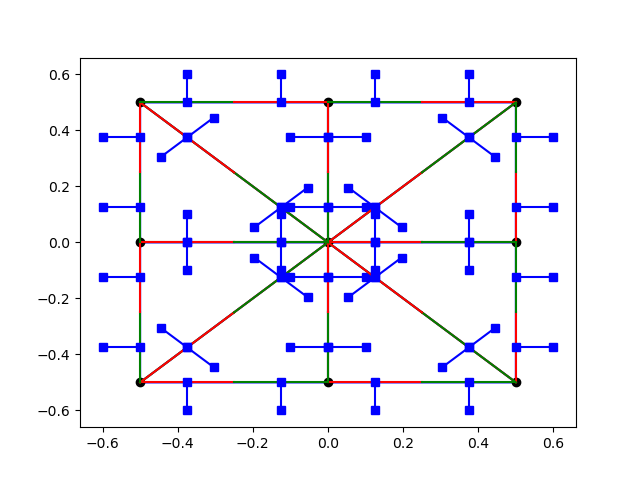

In [7]:
info = MeshInfo(V,T)

CVs = []
for v in range(len(V)):
    cv = VertexControlVolume(v,info)
    CVs.append(cv)            

fig = plt.figure()
plt.triplot(info.V[:,0],info.V[:,1],info.T,color='b')
for v in range(len(info.V)):
    cv = CVs[v]
    plt.plot(cv.c[0],cv.c[1],'ko')
    
    for e in range(cv.K):
        start = cv.c
        end = cv.c + cv.Sij[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
                   
        start = cv.c
        end = cv.c + cv.Sik[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-g')

        start = cv.c+cv.Sij[e]/2
        end = cv.c+cv.Sij[e]/2 + cv.Nij[e]*0.1
        plt.plot([start[0], end[0]],[start[1], end[1]],'-bs')
                   
        start = cv.c+cv.Sik[e]/2
        end = cv.c+cv.Sik[e]/2 + cv.Nik[e]*0.1
        plt.plot([start[0], end[0]],[start[1], end[1]],'-bs')
plt.show()    

Next will will render the control volume shapes so we can see how they look like. They have a very specific shape and it is easy to verify by visual inspection if they have been created correctly.

c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


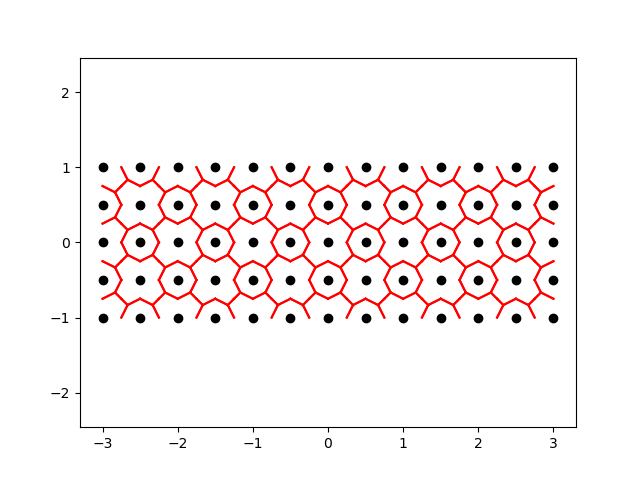

In [8]:
V, T = make_beam_mesh(6.0,2.0,(12,4))

info = MeshInfo(V,T)

CVs = []
for v in range(len(V)):
    cv = VertexControlVolume(v,info)
    CVs.append(cv)

fig = plt.figure()
ax = plt.subplot(111)
for v in range(len(CVs)):
    cv = CVs[v]
    plt.plot(cv.c[0],cv.c[1],'ko')
    for e in range(cv.K):
        start = cv.c + cv.Sij[e]
        end = cv.P[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
        start = cv.c + cv.Sik[e]
        end = cv.P[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
ax.axis('equal')
plt.show()

# Creating a 2D Hyperelastic Simualtor

This is your task to implement this...

In [9]:
def plot_state(V, T, vels, f_elastic, f_other, f_total, x_lim, y_lim, i):
    _, ax = plt.subplots()
    ax.triplot(V[:, 0], V[:, 1], T)
    temp_info = MeshInfo(V, T)
    temp_CVs = [
        VertexControlVolume(v, temp_info) \
        for v in range(len(V))
    ]
    for cv in temp_CVs:
        plt.plot(cv.c[0],cv.c[1],'ko')
        for e in range(cv.K):
            start = cv.c + cv.Sij[e]
            end = cv.P[e]
            plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
            start = cv.c + cv.Sik[e]
            end = cv.P[e]
            plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
    if vels is not None:
        ax.quiver(V[:, 0], V[:, 1], vels[:, 0], vels[:, 1])
    if f_elastic is not None:
        ax.quiver(V[:, 0], V[:, 1], f_elastic[:, 0], f_elastic[:, 1], color='r')
    if f_other is not None:
        ax.quiver(V[:, 0], V[:, 1], f_other[:, 0], f_other[:, 1], color='g')
    if f_total is not None:
        ax.quiver(V[:, 0], V[:, 1], f_total[:, 0], f_total[:, 1], color='b')
    
    ax.set_title(f"iteration {i}")
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    plt.show()

In [10]:
class SimConstants:

    def __init__(self, E, nu, rho, g):
        self.E = E                  # Young's modulus
        self.nu = nu                # Poisson's ratio
        self.rho = rho              # mass density
        self.g = g                  # gravity acceleration

        self.lam = (E * nu) /((1 + nu) * (1 - 2 * nu))  # Lame 1st
        self.mu = E / (2 * (1 + nu))                    # Lame 2nd



class CompMesh:

    def __init__(self, V, T):
        self.V0 = V.copy() # vertex coordinates in material coordinates
        self.V = V         # vertex coordinates in spatial coordinates
        self.T = T
        self.V_len = len(V)
        self.info = MeshInfo(self.V, self.T)
        self.CVs = [ 
            VertexControlVolume(v, self.info) \
                for v in range(self.V_len) 
        ]

        # data stored at each control volume / vertex
        self.vels = np.zeros((self.V_len, 2), dtype=np.float64)

        # data stored at each triangle
        MAX_NEIGHBOURING_TRIANGLES = 8
        self.D0_inv = np.zeros((self.V_len, MAX_NEIGHBOURING_TRIANGLES, 2, 2),
                           dtype=np.float64)

        # data stored at each edge
        self.Lij0 = np.zeros((self.V_len, MAX_NEIGHBOURING_TRIANGLES),
                             dtype=np.float64)  # edge lengths
        self.Lik0 = np.zeros((self.V_len, MAX_NEIGHBOURING_TRIANGLES),
                             dtype=np.float64)  # edge lengths
        self.Nij0 = np.zeros((self.V_len, MAX_NEIGHBOURING_TRIANGLES, 2),
                             dtype=np.float64)  # edge normals
        self.Nik0 = np.zeros((self.V_len, MAX_NEIGHBOURING_TRIANGLES, 2),
                             dtype=np.float64)  # edge normals

        # precompute the reference arrays
        for i, cv in enumerate(self.CVs):
            for e in range(cv.K):
                self.Lij0[i, e] = cv.Lij[e]
                self.Lik0[i, e] = cv.Lik[e]
                self.Nij0[i, e] = cv.Nij[e]
                self.Nik0[i, e] = cv.Nik[e]
                
                Sij = cv.Sij[e]
                Sik = cv.Sik[e]
                Die0 = np.array([Sij, Sik]).T
                self.D0_inv[i, e] = np.linalg.inv(Die0)


class Sim:
    def __init__(self, V, T, consts, dt, duration, g_d, t, t_d, t_labels, 
                 Dirichlet_value, Dirichlet_labels): 
        '''
        V: vertices
        T: triangles
        consts: simulation constants
        dt: time step
        duration: duration of simulation
        g_d: gravity direction
        t: traction
        t_d: traction direction
        t_labels: vertex labels of vertices where traction is applied
        Dirichlet_value: values of Dirichlet boundary conditions
        Dirichlet_labels: vertex labels of vertices where Dirichlet boundary 
                          conditions are applied
        '''
        self.consts = consts
        self.comp_mesh = CompMesh(V, T)
        self.dt = dt
        self.duration = duration
        self.g_d = g_d
        self.t = t
        self.t_d = t_d
        self.t_labels = t_labels
        self.Dirichlet_value = Dirichlet_value
        self.Dirichlet_labels = Dirichlet_labels

    def compute_psy(self, E):
        '''
        Compute the strain energy density
            E: strain tensor
        '''
        lam = self.consts.lam
        mu = self.consts.mu
        return (lam / 2) * (np.trace(E)**2) + mu * np.trace(E**2)
        
    def compute_elastic(self):
        '''
        Compute the elastic force and strain energy density
        '''
        fi = np.zeros((self.comp_mesh.V_len, 2), dtype=np.float64)
        e_elastic_arry = np.zeros((len(self.comp_mesh.T)), dtype=np.float64)
        for i, cv in enumerate(self.comp_mesh.CVs):
            
            Tris = self.comp_mesh.T[cv.labels]
            for t in range(len(Tris)):
                Tris[t,:] = get_cyclic_permuation(i, Tris[t,:])
                
            for e in range(cv.K):
                pi = self.comp_mesh.V[Tris[e, 0]]
                pj = self.comp_mesh.V[Tris[e, 1]]
                pk = self.comp_mesh.V[Tris[e, 2]]

                Sij = (pj - pi)
                Sik = (pk - pi)
                tri_idx = cv.labels[e]
                Ae = 0.5 * np.cross(Sij, Sik)

                Sij /= 2
                Sik /= 2
                De = np.array([Sij, Sik]).T
                D0_inv = self.comp_mesh.D0_inv[i, e]
                
                lam = self.consts.lam
                mu = self.consts.mu
                Nij0 = self.comp_mesh.Nij0[i, e]
                Nik0 = self.comp_mesh.Nik0[i, e]
                Lij0 = self.comp_mesh.Lij0[i, e]
                Lik0 = self.comp_mesh.Lik0[i, e]

                Fe = De @ D0_inv
                Ee  = 0.5 * (Fe.T @ Fe - np.eye(2))
                Se = lam * np.trace(Ee) * np.eye(2) + 2 * mu * Ee
                Pe = Fe @ Se

                e_elastic_arry[tri_idx] = Ae * self.compute_psy(Ee) 

                fi[i] += - (Pe @ Nij0 * Lij0) - (Pe @ Nik0 * Lik0)
        
        return fi, sum(e_elastic_arry)
    
    def compute_F_external(self):
        '''
        Compute the external force at each vertex
            n: the direction of the external force
        '''
        fi = np.zeros((self.comp_mesh.V_len, 2), dtype=np.float64)
        rho = self.consts.rho
        g = self.consts.g
        for i, cv in enumerate(self.comp_mesh.CVs):
            fi[i] += rho * cv.A * g * self.g_d
        return fi
    
    def compute_F_traction(self):
        '''
        Compute the traction force at each vertex
            t: the traction force density
            n: the direction of the traction force
            CV_labels: the labels of the control volumes where the traction
        '''
        fi = np.zeros((self.comp_mesh.V_len, 2), dtype=np.float64)
        for i, cv in enumerate(self.comp_mesh.CVs):
            if i in self.t_labels:
                fi[i] += self.t * self.t_d * cv.A
        return fi
    
    def compute_gravitational_energy(self):
        '''
        Compute the gravitational energy
        '''
        rho = self.consts.rho
        g = self.consts.g
        e_grav_array = np.zeros(self.comp_mesh.V_len, dtype=np.float64)
        dhs = self.comp_mesh.V[:, 1] - self.comp_mesh.V0[:, 1]
        for i, cv in enumerate(self.comp_mesh.CVs):
            A = cv.A
            m = rho * A
            dh = dhs[i]
            e_grav_array[i] = m * g * dh

        return sum(e_grav_array)
    
    def compute_kinetic_energy(self):
        '''
        Compute the kinetic energy
        '''
        rho = self.consts.rho
        e_kin_array = np.zeros(self.comp_mesh.V_len, dtype=np.float64)
        for i, cv in enumerate(self.comp_mesh.CVs):
            A = cv.A
            m = rho * A
            v = self.comp_mesh.vels[i]
            e_kin_array[i] = 0.5 * m * np.linalg.norm(v)**2
        
        return sum(e_kin_array)
    
    def apply_Dirichlet(self, f_total):
        '''
        Apply Dirichlet boundary conditions
        '''
        for i in self.Dirichlet_labels:
            f_total[i] = self.Dirichlet_value

    def update_velocities(self, f_total):
        '''
        Compute the new velocity at each vertex
            f_total: the total force at each vertex
        '''
        dt = self.dt
        rho = self.consts.rho
        for i, cv in enumerate(self.comp_mesh.CVs):
            self.comp_mesh.vels[i] += dt * f_total[i] / (rho * cv.A)

    def update_positions(self):
        '''
        Compute the new position at each vertex
        '''
        dt = self.dt
        for i in range(len(self.comp_mesh.CVs)):
            self.comp_mesh.V[i] += dt * self.comp_mesh.vels[i]

    def run(self):
        '''
        Run the simulation
        '''
        duration = self.duration
        dt = self.dt

        t_current = 0
        iterations = 0
        # just for debugging
        f_elastic = None
        f_other = None
        f_total = None
        e_elastic_list = []
        e_grav_list = []
        e_kin_list = []
        while t_current < duration:

            # if iterations % 100 == 0:
            #     # plot the current state
            #     plot_state(
            #         self.comp_mesh.V, 
            #         self.comp_mesh.T, 
            #         self.comp_mesh.vels, 
            #         f_elastic,
            #         f_other,
            #         f_total,
            #         (-3.5, 4),
            #         (-3.5, 2),
            #         iterations
            #     )
            
            # compute the elastic force and strain energy density
            f_elastic, elastic_energy = self.compute_elastic()

            if iterations == 0: # only compute once
                # compute the external force / the gravity force
                f_external = self.compute_F_external()
                # compute the traction force
                f_traction = self.compute_F_traction()
                

            if t_current < 0.2: # only apply the traction force in the first 0.2s
                f_other = f_external + f_traction
            else:
                f_other = f_external

            # compute the total force
            f_total = f_elastic + f_other

            # compute the energies
            e_elastic_list.append(elastic_energy)
            e_grav_list.append(self.compute_gravitational_energy())
            e_kin_list.append(self.compute_kinetic_energy())

            # apply Dirichlet boundary conditions
            self.apply_Dirichlet(f_total)

            # update the velocity
            self.update_velocities(f_total)

            # update the position
            self.update_positions()

            # update the current time
            t_current += dt

            # update the number of iterations
            iterations += 1

        return self.comp_mesh.V, \
                np.array(e_elastic_list), \
                np.array(e_grav_list), \
                np.array(e_kin_list)


        

In [11]:
V, T = make_beam_mesh(6.0,2.0,(14,4))

consts = SimConstants(
    E=10e5,      # Young's modulus
    nu=0.3,     # Poisson's ratio
    rho=100,    # mass density
    g=9.81,       # gravity acceleration
)

LB = np.array(np.where(V[:,0]<-2.9), dtype=np.int).flatten()
RB = np.array(np.where(V[:,0]>2.9), dtype=np.int).flatten() 

sim = Sim(
    V=V,
    T=T,
    consts=consts,
    dt=0.001,
    duration=5,
    g_d=np.array([0, 0]),
    t=20000,
    t_d=np.array([0, -1]),
    t_labels=RB,
    Dirichlet_value=np.array([0, 0]),
    Dirichlet_labels=LB,
)

V_final, e_elastic_array, e_grav_array, e_kin_array = sim.run()

c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

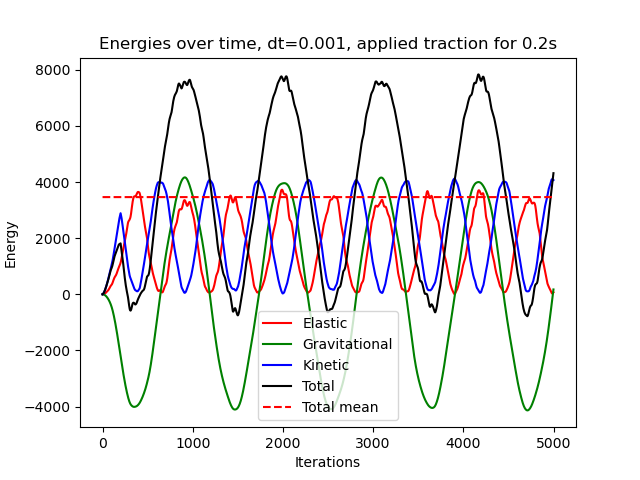

In [12]:
# plot the energies
_, ax = plt.subplots()
ax.plot(e_elastic_array, 'r', label='Elastic')
ax.plot(e_grav_array, 'g', label='Gravitational')
ax.plot(e_kin_array, 'b', label='Kinetic')
total_energy = e_elastic_array + e_grav_array + e_kin_array
ax.plot(total_energy, 'k', label='Total')
# plot the average energy
ax.plot(np.ones_like(total_energy) * np.mean(total_energy), 'r--', label='Total mean')
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.set_title(f'Energies over time, dt={sim.dt}, applied traction for 0.2s')
ax.legend()
plt.show()
